# Rakuten Image Classification - Production ViT Training

**Objectif:** Entraîner le modèle Vision Transformer (google/vit-base-patch16-224) sur l'ensemble complet des données.

**Matériel:** NVIDIA RTX 3060 Ti (8GB VRAM)

**Stratégie:**
- Transfer learning avec ViT pré-entraîné
- Optimiseur AdamW avec warmup scheduler
- Early stopping basé sur la validation accuracy
- Monitoring en temps réel avec graphiques

**Résultats attendus:**
- Temps d'entraînement: ~3-4 heures pour 20 epochs
- Val accuracy: ~50-60%
- Checkpoints sauvegardés dans: `/workspace/checkpoints/vit_production/`

## 1. Configuration

In [1]:
# Imports standards
import sys
import os
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm
import json
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from torch.cuda.amp import GradScaler
import wandb

# Imports transformers
from transformers import ViTForImageClassification, get_scheduler
from torch.optim import AdamW

# Add project root and scripts to path
project_root = Path.cwd().parent.parent
scripts_dir = project_root / "scripts"
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
if str(scripts_dir) not in sys.path:
    sys.path.insert(0, str(scripts_dir))

# Import rakuten modules
from src.rakuten_image.datasets import RakutenImageDataset
from load_data import split_data

print("✓ All modules imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

wandb.login()

✓ All modules imported successfully
PyTorch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3060 Ti
VRAM: 8.36 GB


wandb: Currently logged in as: xiaosong-dev (xiaosong-dev-formation-data-science) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
# ============================================================================
# CONFIGURATION D'ENTRAÎNEMENT
# ============================================================================

CONFIG = {
    # Chemins des données
    "data_dir": Path("/workspace/data"),
    "img_dir": Path("/workspace/data/images/image_train"),
    "checkpoint_dir": Path("/workspace/checkpoints/vit_production"),

    # Configuration du modèle
    "model_name": "google/vit-base-patch16-224",
    "img_size": 224,

    # Hyperparamètres d'entraînement
    "batch_size": 32,  # Augmenté à 32 avec AMP pour RTX 3060 Ti 8GB
    "num_epochs": 20,
    "learning_rate": 2e-5,
    "weight_decay": 0.05,
    "warmup_ratio": 0.1,

    # Split train/validation (85% train, 15% validation)
    "val_split": 0.15,
    "random_state": 42,

    # Early stopping
    "early_stopping_patience": 3,

    # Configuration hardware
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_workers": 2,
    "use_amp": True,  # Utiliser Automatic Mixed Precision
}

print("=" * 80)
print("🚀 CONFIGURATION ViT PRODUCTION")
print("=" * 80)
print(f"Device: {CONFIG['device']}")
print(f"Modèle: {CONFIG['model_name']}")
print(f"Taille d'image: {CONFIG['img_size']}x{CONFIG['img_size']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Epochs max: {CONFIG['num_epochs']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Warmup ratio: {CONFIG['warmup_ratio']}")
print(f"Val split: {CONFIG['val_split']} ({int(CONFIG['val_split']*100)}%)")
print(f"Early stopping patience: {CONFIG['early_stopping_patience']}")
print(f"AMP activé: {CONFIG['use_amp']}")
print(f"Répertoire checkpoints: {CONFIG['checkpoint_dir']}")
print("=" * 80)

🚀 CONFIGURATION ViT PRODUCTION
Device: cuda
Modèle: google/vit-base-patch16-224
Taille d'image: 224x224
Batch size: 32
Epochs max: 20
Learning rate: 2e-05
Warmup ratio: 0.1
Val split: 0.15 (15%)
Early stopping patience: 3
AMP activé: True
Répertoire checkpoints: /workspace/checkpoints/vit_production


## 2. Chargement et Préparation des Données

In [3]:
print("\n📂 Loading data...")

# Use unified split function (SAME as text notebooks!)
X_dev, X_holdout, y_dev, y_holdout = split_data()

# Create full dataframes
df_dev = X_dev.copy()
df_dev['prdtypecode'] = y_dev

df_holdout = X_holdout.copy()
df_holdout['prdtypecode'] = y_holdout

print(f"✓ Data loaded: {len(df_dev) + len(df_holdout):,} total samples")
print(f"  Development: {len(df_dev):,} samples (85%)")
print(f"  Hold-out:    {len(df_holdout):,} samples (15%)")
print(f"  Unique classes: {df_dev['prdtypecode'].nunique()}")

# Global Label Encoding
print("\n🔧 Label encoding...")
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
# Fit on combined data to ensure all classes are seen
all_labels = pd.concat([df_dev['prdtypecode'], df_holdout['prdtypecode']])
label_encoder.fit(all_labels)

df_dev['encoded_label'] = label_encoder.transform(df_dev['prdtypecode'])
df_holdout['encoded_label'] = label_encoder.transform(df_holdout['prdtypecode'])

num_classes = len(label_encoder.classes_)
print(f"✓ Encoding complete")
print(f"  Encoded range: 0 to {num_classes - 1}")
print(f"  Total classes: {num_classes}")
assert num_classes == 27, f"Expected 27 classes, got {num_classes}"

print("\n⚠️  IMPORTANT: Using SAME split as text notebooks!")
print("⚠️  This ensures consistent evaluation across modalities")


📂 Loading data...
✓ Data loaded: 84,916 total samples
  Development: 72,178 samples (85%)
  Hold-out:    12,738 samples (15%)
  Unique classes: 27

🔧 Label encoding...
✓ Encoding complete
  Encoded range: 0 to 26
  Total classes: 27

⚠️  IMPORTANT: Using SAME split as text notebooks!
⚠️  This ensures consistent evaluation across modalities


In [4]:
print("\n" + "=" * 80)
print("Data Cleaning & Train/Val Split")
print("=" * 80)

# Data cleaning (development set)
print("\n🔧 Data cleaning (development set)...")
original_dev_size = len(df_dev)

missing_images_dev = []
for idx, row in df_dev.iterrows():
    imageid = int(row['imageid'])
    productid = int(row['productid'])
    img_path = CONFIG["img_dir"] / f"image_{imageid}_product_{productid}.jpg"
    if not img_path.exists():
        missing_images_dev.append(idx)

if missing_images_dev:
    df_dev = df_dev.drop(missing_images_dev)
    print(f"  Removed {len(missing_images_dev)} samples with missing images")

print(f"✓ Development set after cleaning: {len(df_dev):,} samples")

# Data cleaning (hold-out set)
print("\n🔧 Data cleaning (hold-out set)...")
original_holdout_size = len(df_holdout)

missing_images_holdout = []
for idx, row in df_holdout.iterrows():
    imageid = int(row['imageid'])
    productid = int(row['productid'])
    img_path = CONFIG["img_dir"] / f"image_{imageid}_product_{productid}.jpg"
    if not img_path.exists():
        missing_images_holdout.append(idx)

if missing_images_holdout:
    df_holdout = df_holdout.drop(missing_images_holdout)
    print(f"  Removed {len(missing_images_holdout)} samples with missing images")

print(f"✓ Hold-out set after cleaning: {len(df_holdout):,} samples")

# Split development set into train/val for hyperparameter tuning
print("\n" + "=" * 80)
print("Development Split (Train/Val for Hyperparameter Tuning)")
print("=" * 80)

from sklearn.model_selection import train_test_split

train_indices, val_indices, _, _ = train_test_split(
    df_dev.index,
    df_dev['encoded_label'],
    test_size=0.15,
    random_state=CONFIG["random_state"],
    stratify=df_dev['encoded_label']
)

df_train = df_dev.loc[train_indices].reset_index(drop=True)
df_val = df_dev.loc[val_indices].reset_index(drop=True)
df_holdout = df_holdout.reset_index(drop=True)

total_samples = len(df_dev) + len(df_holdout)
print(f"✓ Development split complete:")
print(f"  Training:   {len(df_train):,} samples (~{len(df_train)/total_samples*100:.1f}%)")
print(f"  Validation: {len(df_val):,} samples (~{len(df_val)/total_samples*100:.1f}%)")
print(f"  Hold-out:   {len(df_holdout):,} samples (15.0%)")

print("\n" + "=" * 80)
print("DATA SPLIT SUMMARY")
print("=" * 80)
print(f"Total: {total_samples:,} samples")
print(f"  1. Training:   {len(df_train):,} (for model training)")
print(f"  2. Validation: {len(df_val):,} (for hyperparameter tuning)")
print(f"  3. Hold-out:   {len(df_holdout):,} (for final evaluation)")
print()
print("⚠️  CRITICAL: This split is IDENTICAL to text notebooks!")
print("⚠️  Image and text models evaluated on same hold-out samples")
print("=" * 80)


Data Cleaning & Train/Val Split

🔧 Data cleaning (development set)...
✓ Development set after cleaning: 72,178 samples

🔧 Data cleaning (hold-out set)...
✓ Hold-out set after cleaning: 12,738 samples

Development Split (Train/Val for Hyperparameter Tuning)
✓ Development split complete:
  Training:   61,351 samples (~72.2%)
  Validation: 10,827 samples (~12.8%)
  Hold-out:   12,738 samples (15.0%)

DATA SPLIT SUMMARY
Total: 84,916 samples
  1. Training:   61,351 (for model training)
  2. Validation: 10,827 (for hyperparameter tuning)
  3. Hold-out:   12,738 (for final evaluation)

⚠️  CRITICAL: This split is IDENTICAL to text notebooks!
⚠️  Image and text models evaluated on same hold-out samples


In [5]:
print("\n🔧 Création des datasets et dataloaders...")

# Transformations pour l'entraînement (avec augmentation)
train_transform = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=2, magnitude=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Transformations pour validation/test (sans augmentation)
val_transform = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Créer les datasets (utilisant encoded_label au lieu de prdtypecode)
train_dataset = RakutenImageDataset(
    dataframe=df_train,
    image_dir=CONFIG["img_dir"],
    transform=train_transform,
    label_col="encoded_label"
)

val_dataset = RakutenImageDataset(
    dataframe=df_val,
    image_dir=CONFIG["img_dir"],
    transform=val_transform,
    label_col="encoded_label"
)

test_dataset = RakutenImageDataset(
    dataframe=df_holdout,
    image_dir=CONFIG["img_dir"],
    transform=val_transform,
    label_col="encoded_label"
)

print(f"✓ Datasets créés")
print(f"  Training:   {len(train_dataset):,} échantillons")
print(f"  Validation: {len(val_dataset):,} échantillons")
print(f"  Hold-out:   {len(test_dataset):,} échantillons")
print(f"  Classes:    {train_dataset.num_classes}")

# Créer les dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=CONFIG["num_workers"],
    pin_memory=True,
    drop_last=True  # Pour stabilité BatchNorm
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

print(f"\n✓ DataLoaders créés (batch_size={CONFIG['batch_size']})")
print(f"  Train:      {len(train_loader):,} batches")
print(f"  Validation: {len(val_loader):,} batches")
print(f"  Hold-out:   {len(test_loader):,} batches")

# Sanity check
try:
    images, labels = next(iter(train_loader))
    print(f"\n✓ Sanity check: Batch shape {images.shape}, Labels {labels.shape}")
    print(f"✅ All DataLoaders working correctly!")
except Exception as e:
    print(f"❌ Error: {e}")


🔧 Création des datasets et dataloaders...
Pre-loading paths into memory...
Dataset initialized with 61351 samples.
Pre-loading paths into memory...
Dataset initialized with 10827 samples.
Pre-loading paths into memory...
Dataset initialized with 12738 samples.
✓ Datasets créés
  Training:   61,351 échantillons
  Validation: 10,827 échantillons
  Hold-out:   12,738 échantillons
  Classes:    27

✓ DataLoaders créés (batch_size=32)
  Train:      1,917 batches
  Validation: 339 batches
  Hold-out:   399 batches

✓ Sanity check: Batch shape torch.Size([32, 3, 224, 224]), Labels torch.Size([32])
✅ All DataLoaders working correctly!


## 3. Initialisation du Modèle

In [6]:
print("\n🏗️ Initialisation du modèle ViT...")

# Charger le modèle pré-entraîné
model = ViTForImageClassification.from_pretrained(
    CONFIG["model_name"],
    num_labels=num_classes,  # Utiliser num_classes de l'encodage global
    ignore_mismatched_sizes=True,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)
model.to(CONFIG["device"])

print(f"✓ Modèle chargé: {CONFIG['model_name']}")
print(f"  Nombre de classes: {num_classes}")

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"  Paramètres totaux: {total_params:,}")
print(f"  Paramètres entraînables: {trainable_params:,}")


🏗️ Initialisation du modèle ViT...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([27]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([27, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Modèle chargé: google/vit-base-patch16-224
  Nombre de classes: 27
  Paramètres totaux: 85,819,419
  Paramètres entraînables: 85,819,419


In [7]:
print("\n⚙️ Configuration de l'optimiseur et du scheduler...")

# Optimiseur AdamW
optimizer = AdamW(
    model.parameters(),
    lr=CONFIG["learning_rate"],
    weight_decay=CONFIG["weight_decay"]
)

# Scheduler avec warmup linéaire
total_steps = len(train_loader) * CONFIG["num_epochs"]
num_warmup_steps = int(total_steps * CONFIG["warmup_ratio"])

scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)

# Initialiser GradScaler pour AMP
scaler = torch.amp.GradScaler('cuda') if CONFIG["use_amp"] else None

print(f"✓ Optimiseur: AdamW")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Weight decay: {CONFIG['weight_decay']}")
print(f"✓ Scheduler: Linear warmup")
print(f"  Warmup steps: {num_warmup_steps:,}/{total_steps:,}")
if CONFIG["use_amp"]:
    print(f"✓ GradScaler initialisé pour AMP")

# Créer le répertoire de checkpoints
CONFIG["checkpoint_dir"].mkdir(parents=True, exist_ok=True)
print(f"✓ Répertoire checkpoints: {CONFIG['checkpoint_dir']}")

# Sauvegarder la configuration
with open(CONFIG["checkpoint_dir"] / "config.json", "w") as f:
    json.dump({k: str(v) for k, v in CONFIG.items()}, f, indent=2)
print(f"✓ Configuration sauvegardée")


⚙️ Configuration de l'optimiseur et du scheduler...
✓ Optimiseur: AdamW
  Learning rate: 2e-05
  Weight decay: 0.05
✓ Scheduler: Linear warmup
  Warmup steps: 3,834/38,340
✓ GradScaler initialisé pour AMP
✓ Répertoire checkpoints: /workspace/checkpoints/vit_production
✓ Configuration sauvegardée


## 4. Entraînement avec Monitoring en Temps Réel

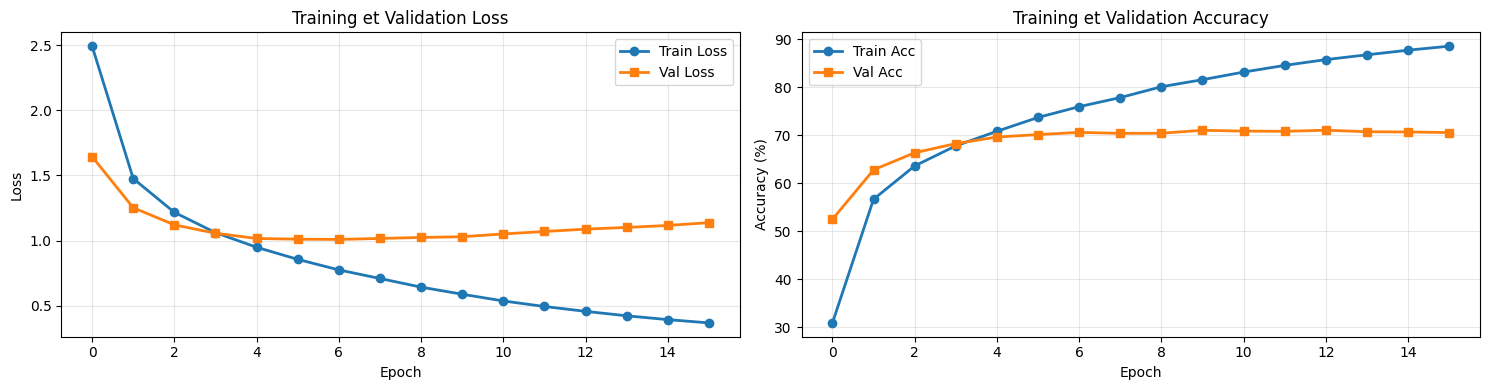


📊 Statistiques actuelles:
  Meilleure Val Acc: 71.05% (Patience: 3/3)
  Meilleure Val Loss: 1.0883

⚠️ Early stopping déclenché après 16 epochs

✅ ENTRAÎNEMENT TERMINÉ


In [8]:
print("\n" + "=" * 80)

# Detect execution environment
import sys
ENVIRONMENT = "colab" if 'google.colab' in sys.modules else "local"

print("🚀 DÉMARRAGE DE L'ENTRAÎNEMENT")
print("=" * 80)
print(f"Temps estimé: ~{len(train_loader) * CONFIG['num_epochs'] * 0.8 / 60:.0f} minutes")
print(f"AMP activé: {CONFIG['use_amp']}")
print("=" * 80 + "\n")

# Initialize WandB

wandb.init(
    project="rakuten-image",
    entity="xiaosong-dev-formation-data-science",
    name=f"vit_v2_{datetime.now().strftime('%Y%m%d_%H%M')}",
    tags=["image", "vit", "v2", "production", ENVIRONMENT],
    config=CONFIG,
    notes="Vision Transformer v2 with improved data augmentation"
)

# Variables pour le tracking
best_val_acc = 0.0
best_val_loss = float('inf')
patience_counter = 0
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

# Fonction pour mettre à jour les graphiques
def update_plots():
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    
    # Plot Loss
    axes[0].plot(history["train_loss"], label='Train Loss', marker='o', linewidth=2)
    axes[0].plot(history["val_loss"], label='Val Loss', marker='s', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training et Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot Accuracy
    axes[1].plot(history["train_acc"], label='Train Acc', marker='o', linewidth=2)
    axes[1].plot(history["val_acc"], label='Val Acc', marker='s', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training et Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Afficher les statistiques
    print(f"\n📊 Statistiques actuelles:")
    print(f"  Meilleure Val Acc: {best_val_acc:.2f}% (Patience: {patience_counter}/{CONFIG['early_stopping_patience']})")
    print(f"  Meilleure Val Loss: {best_val_loss:.4f}")

# Boucle d'entraînement principale
for epoch in range(CONFIG["num_epochs"]):
    print(f"\nEpoch {epoch + 1}/{CONFIG['num_epochs']}")
    print("=" * 80)
    
    # -------------------- Phase d'entraînement --------------------
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc=f"Training", unit="batch")
    for images, labels in train_pbar:
        images, labels = images.to(CONFIG["device"]), labels.to(CONFIG["device"])
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass avec AMP
        if CONFIG["use_amp"]:
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(pixel_values=images, labels=labels)
                loss = outputs.loss
            
            # Backward pass avec scaler
            scaler.scale(loss).backward()
            
            # Unscale avant gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # Optimizer step avec scaler
            scaler.step(optimizer)
            scaler.update()
        else:
            # Forward pass sans AMP
            outputs = model(pixel_values=images, labels=labels)
            loss = outputs.loss
            
            # Backward pass standard
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        
        scheduler.step()
        
        # Métriques
        train_loss += loss.item()
        predictions = torch.argmax(outputs.logits, dim=-1)
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
        
        # Mise à jour de la barre de progression
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.0 * train_correct / train_total:.2f}%'
        })
    
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100.0 * train_correct / train_total
    
    # -------------------- Phase de validation --------------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    val_pbar = tqdm(val_loader, desc=f"Validation", unit="batch")
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(CONFIG["device"]), labels.to(CONFIG["device"])
            
            # Forward pass validation (avec AMP si activé)
            if CONFIG["use_amp"]:
                with torch.amp.autocast(device_type="cuda"):
                    outputs = model(pixel_values=images, labels=labels)
                    loss = outputs.loss
            else:
                outputs = model(pixel_values=images, labels=labels)
                loss = outputs.loss
            
            val_loss += loss.item()
            predictions = torch.argmax(outputs.logits, dim=-1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
            
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.0 * val_correct / val_total:.2f}%'
            })
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * val_correct / val_total
    
    # -------------------- Mise à jour de l'historique --------------------
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(train_accuracy)
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_accuracy)
    
    # Log metrics to WandB
    wandb.log({
        "train_loss": avg_train_loss,
        "train_acc": train_accuracy,
        "val_loss": avg_val_loss,
        "val_acc": val_accuracy,
        "epoch": epoch + 1,
        "learning_rate": optimizer.param_groups[0]['lr']
    })
    
    print(f"\n📊 Résultats Epoch {epoch + 1}:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
    print(f"  Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_accuracy:.2f}%")
    
    # -------------------- Sauvegarde du meilleur modèle --------------------
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_val_loss = avg_val_loss
        patience_counter = 0
        
        checkpoint_path = CONFIG["checkpoint_dir"] / "best_model.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict() if CONFIG["use_amp"] else None,
            'val_acc': val_accuracy,
            'val_loss': avg_val_loss,
            'train_acc': train_accuracy,
            'train_loss': avg_train_loss,
        }, checkpoint_path)
        
        print(f"  ✅ Meilleur modèle sauvegardé! (Val Acc: {val_accuracy:.2f}%)")
    else:
        patience_counter += 1
        print(f"  ⏳ Pas d'amélioration ({patience_counter}/{CONFIG['early_stopping_patience']})")
    
    # -------------------- Mise à jour des graphiques --------------------
    update_plots()
    
    # -------------------- Early Stopping --------------------
    if patience_counter >= CONFIG["early_stopping_patience"]:
        print(f"\n⚠️ Early stopping déclenché après {epoch + 1} epochs")
        break

print("\n" + "=" * 80)
print("✅ ENTRAÎNEMENT TERMINÉ")
print("=" * 80)

## 5. Évaluation Finale

In [9]:
print("\n" + "=" * 80)
print("📊 ÉVALUATION FINALE")
print("=" * 80)

# Charger le meilleur modèle
checkpoint = torch.load(CONFIG["checkpoint_dir"] / "best_model.pth", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"\n✅ Statistiques du meilleur modèle:")
print(f"  Epoch: {checkpoint['epoch']}")
print(f"  Val Accuracy: {checkpoint['val_acc']:.2f}%")
print(f"  Val Loss: {checkpoint.get('val_loss', 'N/A')}")

# Évaluation sur le set de validation
print("\n" + "="*80)
print("Évaluation sur Validation Set")
print("="*80)
all_preds_val = []
all_labels_val = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Validation"):
        images = images.to(CONFIG["device"])
        
        if CONFIG["use_amp"]:
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(pixel_values=images)
        else:
            outputs = model(pixel_values=images)
            
        predictions = torch.argmax(outputs.logits, dim=-1)
        all_preds_val.extend(predictions.cpu().numpy())
        all_labels_val.extend(labels.numpy())

val_acc_final = accuracy_score(all_labels_val, all_preds_val)
print(f"\n✓ Validation Accuracy: {val_acc_final*100:.2f}%")

# Évaluation sur le hold-out test set
print("\n" + "="*80)
print("Évaluation sur Hold-out Test Set (Final Benchmark)")
print("="*80)
all_preds_test = []
all_labels_test = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Hold-out Test"):
        images = images.to(CONFIG["device"])
        
        if CONFIG["use_amp"]:
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(pixel_values=images)
        else:
            outputs = model(pixel_values=images)
            
        predictions = torch.argmax(outputs.logits, dim=-1)
        all_preds_test.extend(predictions.cpu().numpy())
        all_labels_test.extend(labels.numpy())

test_acc_final = accuracy_score(all_labels_test, all_preds_test)
print(f"\n✓ Hold-out Test Accuracy: {test_acc_final*100:.2f}%")

# Rapport de classification détaillé (sur hold-out test)
print("\n📋 Rapport de Classification (Hold-out Test):")
print("=" * 80)
print(classification_report(all_labels_test, all_preds_test, digits=4, zero_division=0))

# Sauvegarder l'historique
history_path = CONFIG["checkpoint_dir"] / "training_history.json"
with open(history_path, "w") as f:
    json.dump(history, f, indent=2)

# Sauvegarder les résultats finaux
results = {
    "best_epoch": int(checkpoint['epoch']),
    "val_acc": float(checkpoint['val_acc']),
    "final_val_acc": float(val_acc_final * 100),
    "final_test_acc": float(test_acc_final * 100),
    "num_classes": int(num_classes),
    "model": CONFIG["model_name"]
}

results_path = CONFIG["checkpoint_dir"] / "final_results.json"
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Historique sauvegardé: {history_path}")
print(f"✅ Résultats finaux sauvegardés: {results_path}")
print(f"✅ Meilleur modèle: {CONFIG['checkpoint_dir'] / 'best_model.pth'}")
print("\n" + "=" * 80)
print("🎉 ÉVALUATION COMPLÈTE")
print("=" * 80)


📊 ÉVALUATION FINALE

✅ Statistiques du meilleur modèle:
  Epoch: 13
  Val Accuracy: 71.05%
  Val Loss: 1.088339806306327

Évaluation sur Validation Set


Validation: 100%|██████████| 339/339 [00:18<00:00, 17.89it/s]



✓ Validation Accuracy: 71.05%

Évaluation sur Hold-out Test Set (Final Benchmark)


Hold-out Test: 100%|██████████| 399/399 [00:21<00:00, 18.56it/s]



✓ Hold-out Test Accuracy: 70.07%

📋 Rapport de Classification (Hold-out Test):
              precision    recall  f1-score   support

           0     0.6401    0.6702    0.6548       467
           1     0.6734    0.7074    0.6900       376
           2     0.5153    0.6032    0.5558       252
           3     0.7748    0.6880    0.7288       125
           4     0.6846    0.6334    0.6580       401
           5     0.9521    0.9393    0.9457       593
           6     0.4454    0.4609    0.4530       115
           7     0.4867    0.4254    0.4540       731
           8     0.4339    0.3376    0.3797       311
           9     0.7232    0.7834    0.7521       757
          10     0.7966    0.7769    0.7866       121
          11     0.5315    0.5187    0.5250       374
          12     0.5556    0.5864    0.5706       486
          13     0.5970    0.6307    0.6134       761
          14     0.8538    0.8406    0.8471       646
          15     0.7521    0.7583    0.7552       120
 

## 6. Sauvegarder les Graphiques Finaux

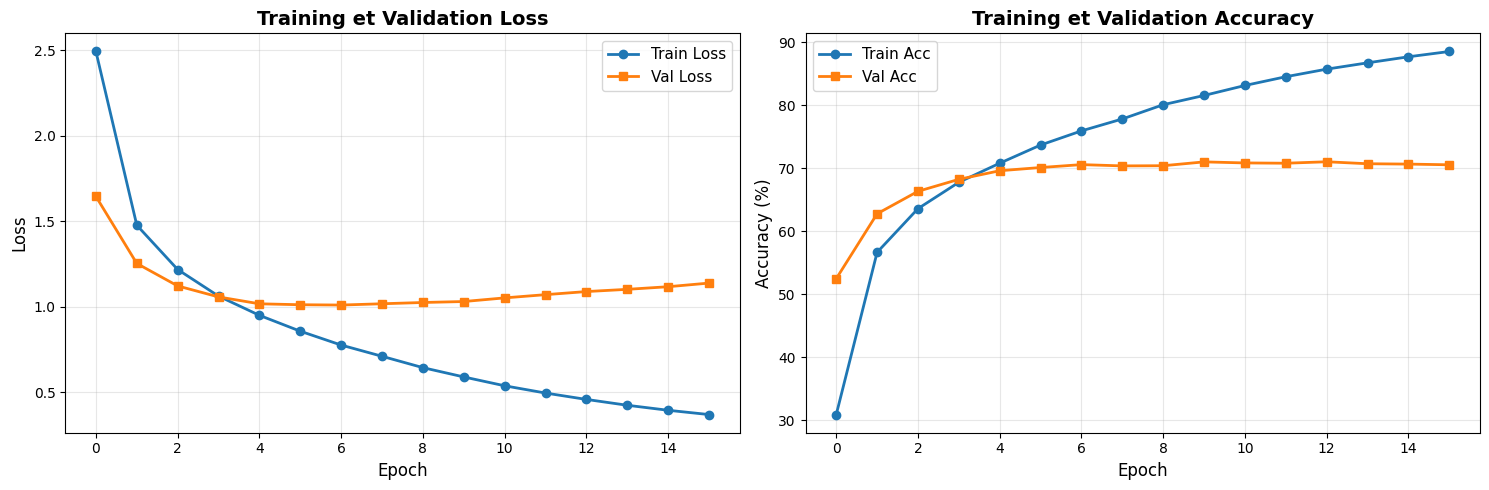

✓ Graphiques sauvegardés: /workspace/checkpoints/vit_production/training_curves.png


In [10]:
# Créer et sauvegarder les graphiques finaux
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
axes[0].plot(history["train_loss"], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history["val_loss"], label='Val Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training et Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
axes[1].plot(history["train_acc"], label='Train Acc', marker='o', linewidth=2)
axes[1].plot(history["val_acc"], label='Val Acc', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training et Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = CONFIG["checkpoint_dir"] / 'training_curves.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Graphiques sauvegardés: {plot_path}")

## 7. Résumé Final

In [11]:
print("=" * 80)
print("📊 RÉSUMÉ DE L'ENTRAÎNEMENT")
print("=" * 80)

total_samples = len(df_dev) + len(df_holdout)

print(f"\nDonnées:")
print(f"  Total échantillons: {total_samples:,}")
print(f"  Training: {len(train_dataset):,} (~{len(train_dataset)/total_samples*100:.1f}%)")
print(f"  Validation: {len(val_dataset):,} (~{len(val_dataset)/total_samples*100:.1f}%)")
print(f"  Hold-out: {len(test_dataset):,} (15.0%)")
print(f"  Classes: {num_classes}")

print(f"\nModèle:")
print(f"  Architecture: {CONFIG['model_name']}")
print(f"  Paramètres entraînables: {trainable_params:,}")

print(f"\nEntraînement:")
print(f"  Epochs complétés: {len(history['train_loss'])}")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")

print(f"\nMeilleurs Résultats (sur Validation):")
print(f"  Best epoch: {checkpoint['epoch']}")
print(f"  Best val accuracy: {checkpoint['val_acc']:.2f}%")

print(f"\nRésultats Finaux:")
print(f"  Final val accuracy: {val_acc_final*100:.2f}%")
print(f"  Final hold-out test accuracy: {test_acc_final*100:.2f}%")

print(f"\nFichiers sauvegardés:")
print(f"  Checkpoint: {CONFIG['checkpoint_dir'] / 'best_model.pth'}")
print(f"  Historique: {CONFIG['checkpoint_dir'] / 'training_history.json'}")
print(f"  Résultats: {CONFIG['checkpoint_dir'] / 'final_results.json'}")
print(f"  Configuration: {CONFIG['checkpoint_dir'] / 'config.json'}")
print(f"  Graphiques: {CONFIG['checkpoint_dir'] / 'training_curves.png'}")

print("\n" + "=" * 80)
print("✅ ENTRAÎNEMENT PRODUCTION ViT TERMINÉ")
print("=" * 80)

# Finish WandB logging
wandb.finish()

📊 RÉSUMÉ DE L'ENTRAÎNEMENT

Données:
  Total échantillons: 84,916
  Training: 61,351 (~72.2%)
  Validation: 10,827 (~12.8%)
  Hold-out: 12,738 (15.0%)
  Classes: 27

Modèle:
  Architecture: google/vit-base-patch16-224
  Paramètres entraînables: 85,819,419

Entraînement:
  Epochs complétés: 16
  Batch size: 32
  Learning rate: 2e-05

Meilleurs Résultats (sur Validation):
  Best epoch: 13
  Best val accuracy: 71.05%

Résultats Finaux:
  Final val accuracy: 71.05%
  Final hold-out test accuracy: 70.07%

Fichiers sauvegardés:
  Checkpoint: /workspace/checkpoints/vit_production/best_model.pth
  Historique: /workspace/checkpoints/vit_production/training_history.json
  Résultats: /workspace/checkpoints/vit_production/final_results.json
  Configuration: /workspace/checkpoints/vit_production/config.json
  Graphiques: /workspace/checkpoints/vit_production/training_curves.png

✅ ENTRAÎNEMENT PRODUCTION ViT TERMINÉ


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
learning_rate,▃█▇▇▇▆▆▅▄▄▃▃▂▂▁▁
train_acc,▁▄▅▅▆▆▆▇▇▇▇█████
train_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_acc,▁▅▆▇▇███████████
val_loss,█▄▂▂▁▁▁▁▁▁▁▂▂▂▂▂
epoch,16
learning_rate,0.0
train_acc,88.56775
train_loss,0.36945
val_acc,70.57357


In [12]:
import torch.nn as nn
import torch.optim as optim
from timm.data.mixup import Mixup
from timm.loss import SoftTargetCrossEntropy
from transformers import get_linear_schedule_with_warmup

# 1. Update Checkpoint Directory
CONFIG["checkpoint_dir"] = Path("/workspace/checkpoints/vit_mixup_v3")
CONFIG["checkpoint_dir"].mkdir(parents=True, exist_ok=True)
print(f"Checkpoint directory set to: {CONFIG['checkpoint_dir']}")

# 2. Configure Mixup/CutMix
mixup_args = {
    'mixup_alpha': 0.8,       # Mixup alpha value
    'cutmix_alpha': 1.0,      # CutMix alpha value
    'cutmix_minmax': None,
    'prob': 1.0,              # Probability of applying mixup or cutmix
    'switch_prob': 0.5,       # Probability of switching to cutmix instead of mixup
    'mode': 'batch',
    'label_smoothing': 0.1,
    'num_classes': 27
}

# Initialize Mixup
mixup_fn = Mixup(**mixup_args)
print("Mixup & CutMix initialized")

# 3. Define Loss Functions
# Training: SoftTargetCrossEntropy (for mixed labels)
criterion_train = SoftTargetCrossEntropy()
# Validation: Standard CrossEntropy (for integer labels)
criterion_val = nn.CrossEntropyLoss()

# 4. Reset Optimizer and Scheduler
# Note: Increased weight_decay to 0.05 for regularization
optimizer = optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=0.05)

# Recalculate steps
num_training_steps = len(train_loader) * CONFIG["num_epochs"]
num_warmup_steps = int(num_training_steps * CONFIG["warmup_ratio"])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)
print("Optimizer and Scheduler reset (Weight Decay = 0.05)")

Checkpoint directory set to: /workspace/checkpoints/vit_mixup_v3
Mixup & CutMix initialized
Optimizer and Scheduler reset (Weight Decay = 0.05)


In [ ]:
from tqdm import tqdm  # Using standard text-based progress bar to avoid IProgress errors
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch

print("\n" + "=" * 80)
print(" STARTING TRAINING (V3 - MIXUP/CUTMIX)")
print("=" * 80)

# Reset tracking variables
best_val_acc = 0.0
patience_counter = 0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

def update_plots_v3():
    """Real-time plotting of training curves."""
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    
    # Plot Loss
    axes[0].plot(history["train_loss"], label='Train Loss', marker='o')
    axes[0].plot(history["val_loss"], label='Val Loss', marker='s')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot Accuracy
    # Note: Train Acc is dashed because it is not fully representative under Mixup
    axes[1].plot(history["train_acc"], label='Train Acc (Mixup)', marker='o', linestyle='--', alpha=0.5)
    axes[1].plot(history["val_acc"], label='Val Acc', marker='s', linewidth=2)
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print(f" Current Best Val Acc: {best_val_acc:.2f}%")

# ============================================================================
# Main Training Loop
# ============================================================================
for epoch in range(CONFIG["num_epochs"]):
    print(f"\nEpoch {epoch + 1}/{CONFIG['num_epochs']}")
    
    # --- 1. Training Phase ---
    model.train()
    train_loss = 0.0
    
    # Use ascii=True for compatibility with all terminals
    train_pbar = tqdm(train_loader, desc="Training", ascii=True)
    
    for images, labels in train_pbar:
        images, labels = images.to(CONFIG["device"]), labels.to(CONFIG["device"])
        
        # ➤ Apply Mixup / CutMix
        if mixup_fn is not None:
            images, labels = mixup_fn(images, labels)
        
        optimizer.zero_grad()
        
        # ➤ Forward Pass & Loss Calculation
        if CONFIG["use_amp"]:
            # Mixed Precision Context
            with torch.cuda.amp.autocast(): 
                # Note: We do not pass labels to the model here
                # We calculate the Mixup Loss manually
                outputs = model(pixel_values=images)
                loss = criterion_train(outputs.logits, labels)
            
            # Backward Pass
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard Precision (FP32)
            outputs = model(pixel_values=images)
            loss = criterion_train(outputs.logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
        scheduler.step()
        train_loss += loss.item()
        
        # Update progress bar
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_train_loss = train_loss / len(train_loader)
    
    # --- 2. Validation Phase ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Validation does not use Mixup and does not need gradients
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc="Validation", ascii=True)
        for images, labels in val_pbar:
            images, labels = images.to(CONFIG["device"]), labels.to(CONFIG["device"])
            
            if CONFIG["use_amp"]:
                with torch.cuda.amp.autocast():
                    outputs = model(pixel_values=images)
                    # Validation uses standard CrossEntropyLoss
                    loss = criterion_val(outputs.logits, labels)
            else:
                outputs = model(pixel_values=images)
                loss = criterion_val(outputs.logits, labels)
                
            val_loss += loss.item()
            # Calculate Accuracy
            preds = torch.argmax(outputs.logits, dim=-1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            
    val_acc = 100.0 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    
    # --- 3. Logging & Saving ---
    # We record 0 for train_acc as it is not meaningful under Mixup
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(0) 
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_acc)
    
    # Save Best Model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'val_acc': val_acc,
            'epoch': epoch + 1,
            'optimizer_state_dict': optimizer.state_dict()
        }, CONFIG["checkpoint_dir"] / "best_model.pth")
        print(f"✅ New best model saved! Val Acc: {val_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"⏳ No improvement ({patience_counter}/3). Best: {best_val_acc:.2f}%")
        
    # Update plots
    update_plots_v3()
    
    # Early Stopping Check
    if patience_counter >= 3:
        print("\n⚠️ Early Stopping Triggered.")
        break

print("\n" + "=" * 80)
print("✅ TRAINING COMPLETE")
print("=" * 80)


 STARTING TRAINING (V3 - MIXUP/CUTMIX)

Epoch 1/20


Training:   0%|          | 0/1917 [00:00<?, ?it/s]/tmp/ipykernel_20651/2820411603.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training:   0%|          | 0/1917 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 7.79 GiB of which 9.00 MiB is free. Process 25129 has 3.69 GiB memory in use. Process 25820 has 4.08 GiB memory in use. Of the allocated memory 3.70 GiB is allocated by PyTorch, and 210.58 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

: 